## Семинар 3 "Определение ключевых точек лица"

ФИО:

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

#### Опциональная часть, которую мы обсудили на семинаре: визуализировать процесс обучения и веса сети в tensorboard
К сожалению, текущая версия pytorch не слишком хорошо работает напрямую с tensorboard. Есть два пути решения. 1. делать все логирование через tensorflow. 2. Воспользоваться нестабильной свежей версией pytorch.

Разберем 2й способ:
Устанавливаем свежий нестабильный pytorch (conda install pytorch-nightly  torchvision -c  pytorch). Если у вас уже установлен pytorch нужно либо удалить его, либо создать новые conda-environment

Устанавливаем совместимую версию tensorboard: pip install tb-nightly. (Аналогично, если у вас уже есть установленный tensorboard, его придется удалить). После установки вам возможно потребуется установить пакет future (pip install future)

Запускаем tensorboard из той же папки, из которой запущен notebook (tensorboard --logdir runs). Со стандартными параметрами он будет доступен по ссылке: localhost:6006

https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


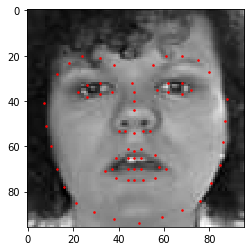

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True)

In [42]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam, writer=None):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                #print(network(X))
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            if writer:
                writer.add_scalar('Loss/train', train_loss_epochs[-1], epoch)
                writer.add_scalar('Loss/test', test_loss_epochs[-1], epoch)
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [43]:
from torch import nn

In [61]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

In [66]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=1)) / x.std(dim=1)
        return output

net = [Flatten()]
sizes = [96**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim))
    #net.append(nn.Linear(in_dim, out_dim))
    #net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 2*68))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

In [67]:
net

Sequential(
  (0): Flatten()
  (1): DropConnect(
    (lin): Linear(in_features=9216, out_features=200, bias=True)
  )
  (2): ReLU()
  (3): DropConnect(
    (lin): Linear(in_features=200, out_features=200, bias=True)
  )
  (4): ReLU()
  (5): Linear(in_features=200, out_features=136, bias=True)
  (6): LogSoftmax()
)

Epoch 4... (Train/Test) MSE: 3858.202/3840.2508.548

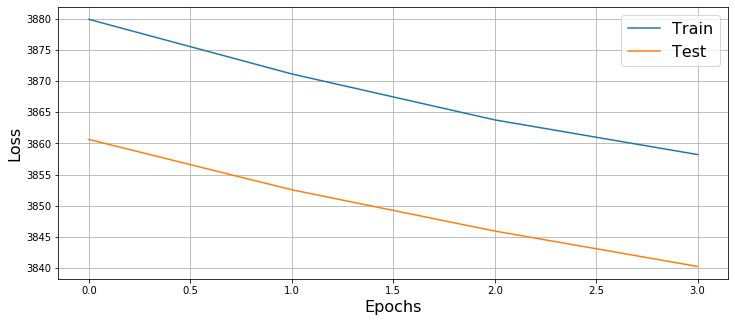

In [68]:
train(net, 5, 1e-1)

In [27]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 96 * 96).type(dtype))
y_pred = network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

RuntimeError: shape '[-1, 68, 2]' is invalid for input of size 20

In [ ]:
def matplotlib_imshow(img, one_channel=False):

    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
from torch.utils.tensorboard import SummaryWriter
# Создаем адаптер между pytorch и tensorboard. Промежуточные файлы будут попадать в папку runs/faces_experiment_1
writer = SummaryWriter('runs/faces_experiment_1')

In [ ]:
dataiter = iter(train_dataloader)

sample= dataiter.next()
images = sample['image']
landmarks = sample['landmarks']
img_grid = utils.make_grid(images.view(64,1,96,96))
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:
# пишем картинку в tensorboard
writer.add_image('faces_batch_images', img_grid)

In [ ]:
# пишем граф сети в tensorboard
# граф появится во вкладке Graphs. 
#при клике на вершину графа, можно посмотреть на структуру оного
writer.add_graph(network,  images.view(images.shape[0], -1).type(dtype).requires_grad_(True))
writer.close()

In [ ]:
# Запускаем обучение с логированием в tensorboard
train(network, 10, 1e-1, writer=writer)

In [ ]:
for module in network.modules():
    print(module)

In [ ]:
# Будем использовать первый слой сети в качестве feature extractor
# с помощью writer.add_embedding визуализируем полученные признаки
# резульат появится во вкладке PROJECTOR

embedder = list(network.modules())[1]

features = embedder(images.view(images.shape[0], -1).type(dtype))
writer.add_embedding(features)